In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from time import time

import xgboost as xgb

import keras
import keras.backend as K

from keras import Sequential, regularizers
from keras.layers import Dense, Dropout, GRU, LSTM, BatchNormalization as BatchNorm
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt

In [2]:
from nba_api.stats.endpoints import (playergamelog, leagueseasonmatchups, boxscoretraditionalv2,
                                     commonteamroster, teamgamelogs, leaguedashptteamdefend,
                                     teamestimatedmetrics)

from nba_api.stats.static import teams, players
from nba_api.stats.library.parameters import SeasonAll

In [ ]:
def fetch_players_id(players_full_name: str) -> int:
    """
    Get players ID given full name

    :param: players_full_name: player's full name
    :return: player's ID
    """
    try:
        players_id = players.find_players_by_full_name(players_full_name)[0]["id"]
    except IndexError:
        print(f"WARNING: {players_full_name} does not have a player ID!")
        players_id = None

    return players_id

In [4]:
metrics_21 = pd.read_csv("data/seasonal_data/2021/defensive_metrics_21.csv", index_col=0)
metrics_22 = pd.read_csv("data/seasonal_data/2022/defensive_metrics_22.csv", index_col=0)
metrics_23 = pd.read_csv("data/seasonal_data/2023/defensive_metrics_23.csv", index_col=0)

In [5]:
def convert_to_float32(df: pd.DataFrame, cols: list=None):
    """
    """
    df[cols] = df[cols].astype(np.float32)
    
    return df

In [6]:
nba_teams = teams.get_teams()
static_team_info = pd.DataFrame(nba_teams)
all_teams_id = static_team_info["id"].values

In [7]:
id_abb_lut = dict(zip(static_team_info["abbreviation"], static_team_info["id"]))

In [8]:
# atl = teamgamelogs.TeamGameLogs(team_id_nullable=1610612737, season_nullable="2022-23").get_data_frames()[0]

In [9]:
# df = leaguedashptteamdefend.LeagueDashPtTeamDefend(
#                                               defense_category="Less Than 10Ft",
#                                               per_mode_simple="PerGame",
#                                               season="2022-23",
#                                               season_type_all_star="Regular Season",
#                                               season_segment_nullable="Post All-Star"
#                                               ).get_data_frames()[0]

In [10]:
# df.to_csv("data/seasonal_data/2023/post_asb_10ft_23.csv")

In [11]:
def get_opp_id(matchup: str):
    matchup_split = matchup.split(" ")
    opp_abb = matchup_split[2]
    team_id = static_team_info[static_team_info["abbreviation"]==opp_abb]["id"].values[0]
    
    return team_id

def add_rest_days(players_game_logs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add rest days column

    :param players_game_logs_df: player's game logs df
    :return: player's game logs df w/ rest days
    """
    players_game_logs_df["GAME_DATE"] = players_game_logs_df["GAME_DATE"].apply(lambda x: x.split(" "))
    players_game_logs_df["GAME_DATE"] = players_game_logs_df["GAME_DATE"].apply(convert_to_timestamp)
    players_game_logs_df = players_game_logs_df.sort_values(by=["GAME_DATE"], ascending=False)
    players_game_logs_df["REST_DAYS"] = players_game_logs_df["GAME_DATE"].diff(periods=-1)
    players_game_logs_df = players_game_logs_df.iloc[:-1, :]
    players_game_logs_df.loc[:, "REST_DAYS"] = players_game_logs_df["REST_DAYS"].dt.days

    return players_game_logs_df

def add_home_away_columns(players_game_logs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add one_hot encoding home or away bool columns

    :param players_game_logs_df: player's game logs df
    :return: player's game logs df w/ home & away columns
    """
    players_game_logs_df.loc[:, ("HOME", "AWAY")] = tf.one_hot(players_game_logs_df["MATCHUP"].\
                                                    apply(detect_home_or_away_games), 2)

    return players_game_logs_df

def detect_home_or_away_games(game: str):
    """
    Detect if a game is on home court or away
    """
    return 1 if "@" in game else 0

def convert_to_timestamp(date_string: str) -> pd.Timestamp:
    """
    Convert a date in string format to pd.Timestamp format
    """
    months_dict = init_months_dict()
    date = pd.Timestamp(f"{date_string[2]}-{months_dict[date_string[0]]}-{date_string[1][:-1]}")

    return date

def init_months_dict() -> dict:
    """
    Create months dictionary
    """
    months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    months_dict = dict(zip(months, range(1, 13)))

    return months_dict

In [35]:
def merge_defensive_stats(season: str, game_log: pd.DataFrame,
                          defensive_stats: list, metrics: pd.DataFrame=None) -> pd.DataFrame:
    """
    """
    all_star_date = f"20{season}-02-14"
    
    pre_asb = game_log[game_log["GAME_DATE"] < all_star_date].merge(defensive_stats[0], on="TEAM_ID")
    
    post_asb = game_log[game_log["GAME_DATE"] >= all_star_date].merge(defensive_stats[1], on="TEAM_ID")
    
    complete_log = pd.concat([pre_asb, post_asb])
    
    if metrics is not None:
        complete_log = complete_log.merge(metrics, on="TEAM_ID")
    
    return complete_log

### 2023 Season

In [36]:
name = "Rudy Gobert"
player = fetch_players_id(name)
log_23 = fetch_players_game_logs_df(player, "2022-23")
log_23["TEAM_ID"] = log_23["MATCHUP"].apply(get_opp_id)
log_23 = add_rest_days(add_home_away_columns(log_23))

pre_teams_d_23 = pd.read_csv("data/seasonal_data/2023/defense_pre_ASB_23.csv", index_col=0)
post_teams_d_23 = pd.read_csv("data/seasonal_data/2023/defense_post_ASB_23.csv", index_col=0)

pre_teams_3pt_23 = pd.read_csv("data/seasonal_data/2023/pre_asb_3pt_23.csv", index_col=0)
post_teams_3pt_23 = pd.read_csv("data/seasonal_data/2023/post_asb_3pt_23.csv", index_col=0)

pre_teams_2pt_23 = pd.read_csv("data/seasonal_data/2023/pre_asb_2pt_23.csv", index_col=0)
post_teams_2pt_23 = pd.read_csv("data/seasonal_data/2023/post_asb_2pt_23.csv", index_col=0)

pre_teams_10ft_23 = pd.read_csv("data/seasonal_data/2023/pre_asb_10ft_23.csv", index_col=0)
post_teams_10ft_23 = pd.read_csv("data/seasonal_data/2023/post_asb_10ft_23.csv", index_col=0)


player_23 = merge_defensive_stats(season="23", game_log=log_23,
                                  defensive_stats=[pre_teams_d_23, post_teams_d_23],
                                  metrics=metrics_23)

player_23 = merge_defensive_stats(season="23", game_log=player_23,
                                  defensive_stats=[pre_teams_3pt_23, post_teams_3pt_23])

player_23 = merge_defensive_stats(season="23", game_log=player_23,
                                  defensive_stats=[pre_teams_2pt_23, post_teams_2pt_23])

player_23 = merge_defensive_stats(season="23", game_log=player_23,
                                  defensive_stats=[pre_teams_10ft_23, post_teams_10ft_23])

### 2022 Season

In [37]:
log_22 = fetch_players_game_logs_df(player, "2021-22")
log_22["TEAM_ID"] = log_22["MATCHUP"].apply(get_opp_id)
log_22 = add_rest_days(add_home_away_columns(log_22))
all_star_22 = "2022-02-14"

pre_teams_d_22 = pd.read_csv("data/seasonal_data/2022/defense_pre_ASB_22.csv", index_col=0)
post_teams_d_22 = pd.read_csv("data/seasonal_data/2022/defense_post_ASB_22.csv", index_col=0)

pre_teams_3pt_22 = pd.read_csv("data/seasonal_data/2022/pre_asb_3pt_22.csv", index_col=0)
post_teams_3pt_22 = pd.read_csv("data/seasonal_data/2022/post_asb_3pt_22.csv", index_col=0)

pre_teams_2pt_22 = pd.read_csv("data/seasonal_data/2022/pre_asb_2pt_22.csv", index_col=0)
post_teams_2pt_22 = pd.read_csv("data/seasonal_data/2022/post_asb_2pt_22.csv", index_col=0)

pre_teams_10ft_22 = pd.read_csv("data/seasonal_data/2022/pre_asb_10ft_22.csv", index_col=0)
post_teams_10ft_22 = pd.read_csv("data/seasonal_data/2022/post_asb_10ft_22.csv", index_col=0)

player_22 = merge_defensive_stats(season="22", game_log=log_22,
                                  defensive_stats=[pre_teams_d_22, post_teams_d_22],
                                  metrics=metrics_22)

player_22 = merge_defensive_stats(season="22", game_log=player_22,
                                  defensive_stats=[pre_teams_3pt_22, post_teams_3pt_22])

player_22 = merge_defensive_stats(season="22", game_log=player_22,
                                  defensive_stats=[pre_teams_2pt_22, post_teams_2pt_22])

player_22 = merge_defensive_stats(season="22", game_log=player_22,
                                  defensive_stats=[pre_teams_10ft_22, post_teams_10ft_22])

### 2021 Season

In [38]:
log_21 = fetch_players_game_logs_df(player, "2020-21")
log_21["TEAM_ID"] = log_21["MATCHUP"].apply(get_opp_id)
log_21 = add_rest_days(add_home_away_columns(log_21))
all_star_21 = "2021-02-14"

pre_teams_d_21 = pd.read_csv("data/seasonal_data/2021/defense_pre_ASB_21.csv", index_col=0)
post_teams_d_21 = pd.read_csv("data/seasonal_data/2021/defense_post_ASB_21.csv", index_col=0)

pre_teams_3pt_21 = pd.read_csv("data/seasonal_data/2021/pre_asb_3pt_21.csv", index_col=0)
post_teams_3pt_21 = pd.read_csv("data/seasonal_data/2021/post_asb_3pt_21.csv", index_col=0)

pre_teams_2pt_21 = pd.read_csv("data/seasonal_data/2021/pre_asb_2pt_21.csv", index_col=0)
post_teams_2pt_21 = pd.read_csv("data/seasonal_data/2021/post_asb_2pt_21.csv", index_col=0)

pre_teams_10ft_21 = pd.read_csv("data/seasonal_data/2021/pre_asb_10ft_21.csv", index_col=0)
post_teams_10ft_21 = pd.read_csv("data/seasonal_data/2021/post_asb_10ft_21.csv", index_col=0)

player_21 = merge_defensive_stats(season="21", game_log=log_21,
                                  defensive_stats=[pre_teams_d_21, post_teams_d_21],
                                  metrics=metrics_21)

player_21 = merge_defensive_stats(season="21", game_log=player_21,
                                  defensive_stats=[pre_teams_3pt_21, post_teams_3pt_21])

player_21 = merge_defensive_stats(season="21", game_log=player_21,
                                  defensive_stats=[pre_teams_2pt_21, post_teams_2pt_21])

player_21 = merge_defensive_stats(season="21", game_log=player_21,
                                  defensive_stats=[pre_teams_10ft_21, post_teams_10ft_21])

In [39]:
complete_log = pd.concat([player_21, player_22, player_23]).sort_values(by=["GAME_DATE"], ascending=False)
complete_log.columns

Index(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M_x', 'FG3A_x', 'FG3_PCT_x', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'TEAM_ID', 'HOME', 'AWAY',
       'REST_DAYS', 'D_FGM', 'D_FGA', 'D_FG_PCT', 'NORMAL_FG_PCT',
       'PCT_PLUSMINUS', 'E_PACE', 'E_DEF_RATING', 'FG3M_y', 'FG3A_y',
       'FG3_PCT_y', 'NS_FG3_PCT', 'PLUSMINUS_x', 'FG2M', 'FG2A', 'FG2_PCT',
       'NS_FG2_PCT', 'PLUSMINUS_y', 'TEAM_NAME', 'TEAM_ABBREVIATION', 'GP',
       'G', 'FREQ', 'FGM_LT_10', 'FGA_LT_10', 'LT_10_PCT', 'NS_LT_10_PCT',
       'PLUSMINUS', 'FREQ_x', 'FREQ_y'],
      dtype='object')

In [40]:
predictors = ["MIN", "FGA", "FG3A_x", "FTA", "HOME", "AWAY", "REST_DAYS",
              "D_FGM", "D_FGA", "D_FG_PCT", "PCT_PLUSMINUS",
              "FG3M_y", "FG3A_y", "FG3_PCT_y", "NS_FG3_PCT", "PLUSMINUS_x",
              "FG2M", "FG2A", "FG2_PCT", "NS_FG2_PCT", "PLUSMINUS_y",
              "FGM_LT_10", "FGA_LT_10", "LT_10_PCT", "NS_LT_10_PCT", "PLUSMINUS",
              "E_PACE", "E_DEF_RATING"]

label1 = ["PTS"]

In [41]:
game_to_predict = 10

X, y = complete_log[predictors].astype(np.float32), complete_log[label1].astype(np.float32)
xtrain, ytrain = X.iloc[game_to_predict:, :].values, y.iloc[game_to_predict:, :].values
xtest, ytest = X.iloc[:game_to_predict, :].values, y.iloc[:game_to_predict, :].values

In [42]:
x_scaler = MinMaxScaler()
x_scaler.fit(xtrain)
xtrain_scaled = x_scaler.transform(xtrain)

y_scaler = MinMaxScaler()
y_scaler.fit(ytrain)
ytrain_scaled = y_scaler.transform(ytrain)

In [43]:
model = Sequential()
model.add(Dense(200, activation="relu", input_shape=(len(predictors), )))
model.add(Dense(200, activation="relu", batch_size=24, kernel_regularizer=regularizers.l1(2e-3)))
model.add(Dropout(0.2)) 
model.add(Dense(200, activation="relu", batch_size=32, kernel_regularizer=regularizers.l2(1e-3)))
model.add(Dropout(0.1))
model.add(Dense(1, activation="relu"))

model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=Adam(learning_rate=2e-4),
              metrics="mse")

In [44]:
start = time()
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-6, patience=10)

model.fit(xtrain, ytrain, batch_size=24, epochs=500, callbacks=[callback],
          verbose=0, validation_split=0.15, )

end = time()
print(f"Training time: {round(end - start, 2)}s")

Training time: 2.03s


In [45]:
# xtest_scaled = x_scaler.transform(xtest)
# forecasts = y_scaler.inverse_transform(model.predict(xtest_scaled).reshape(-1, 1))

forecasts = model.predict(xtest).reshape(-1, )

print(f"Forecasts: {np.round(forecasts)}")
print()
print(f"Actual: {ytest.reshape(-1, )}")

Forecasts: [ 1. 10. 13. 14. 13.  9. 17. 13. 15. 16.]

Actual: [ 2. 10. 12. 10. 14.  7. 16. 10. 12. 16.]


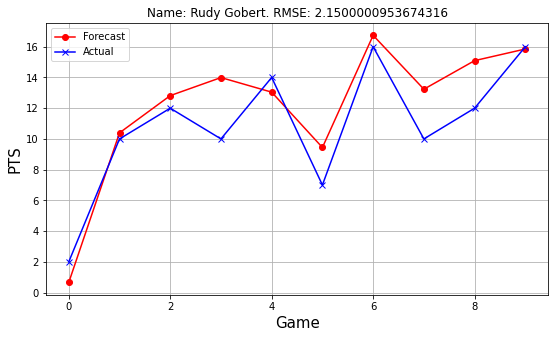

In [46]:
rmse = np.sqrt(mse(forecasts, ytest.reshape(-1, )))

plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(ytest)), forecasts, color="red", marker="o", label="Forecast")
plt.plot(np.arange(len(ytest)), ytest.reshape(-1, ), color="blue", marker="x", label="Actual")
plt.xlabel("Game", fontsize=15)
plt.ylabel(label1[0], fontsize=15)
plt.title(f"Name: {name}. RMSE: {round(rmse, 2)}")
plt.grid()
plt.legend()
plt.show()

### GRU Test

In [47]:
xtrain_ = xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1])

In [48]:
gru = Sequential()

gru.add(GRU(200, return_sequences=True, unroll=True, input_shape=(1, xtrain_.shape[2])))
gru.add(Dropout(0.2))

gru.add(GRU(200, return_sequences=True, batch_size=24, recurrent_dropout=0.1,
            unroll=True, kernel_regularizer=regularizers.l1(2e-3)))
gru.add(Dropout(0.2))

gru.add(GRU(200, return_sequences=True, batch_size=32, recurrent_dropout=0.2,
            unroll=True, kernel_regularizer=regularizers.l2(1e-3)))

gru.add(Dense(1, ))

gru.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=Adam(learning_rate=4e-4),
              metrics="mse")

In [49]:
start = time()
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-6, patience=10)

gru.fit(xtrain_, ytrain, batch_size=24, epochs=500, callbacks=[callback],
        verbose=0, validation_split=0.15, )

end = time()

print(f"Training time: {round(end - start, 2)}s")

Training time: 5.45s


In [50]:
gru_forecasts = gru.predict(xtest.reshape(xtest.shape[0], 1, xtest.shape[1]))
gru_forecasts = np.round(gru_forecasts.reshape(-1, ))

print(f"GRU Forecasts: {gru_forecasts}")
print()
print(f"Actual: {ytest.reshape(-1, )}")

GRU Forecasts: [ 4. 11. 14. 14. 14.  9. 18. 13. 17. 17.]

Actual: [ 2. 10. 12. 10. 14.  7. 16. 10. 12. 16.]


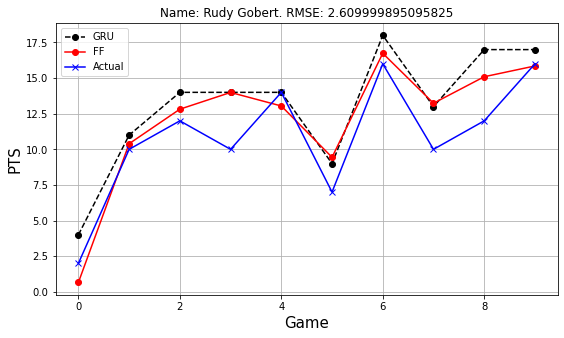

In [51]:
gru_rmse = np.sqrt(mse(gru_forecasts, ytest.reshape(-1, )))

plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(ytest)), gru_forecasts, color="black", linestyle="--", marker="o", label="GRU")
plt.plot(np.arange(len(ytest)), forecasts, color="red", marker="o", label="FF")
plt.plot(np.arange(len(ytest)), ytest.reshape(-1, ), color="blue", marker="x", label="Actual")
plt.xlabel("Game", fontsize=15)
plt.ylabel(label1[0], fontsize=15)
plt.title(f"Name: {name}. RMSE: {round(gru_rmse, 2)}")
plt.grid()
plt.legend()
plt.show()

In [52]:
data_config = {"predictors": predictors, "label": label1,
               "val_split": 10, "test_split": 10}

model_config = {"max_depth": 2, 'eta': 0.3, 'objective': "reg:linear",
                "alpha": 2e-3, "lambda": 2e-3,
                "nthread": 5, "eval_metric": "rmse"}

def create_train_test_split(complete_log: pd.DataFrame, data_config: dict):
    """
    """
    X, y = complete_log[data_config["predictors"]], complete_log[data_config["label"]]
    test_split = data_config["test_split"]
    val_split = data_config["val_split"]
    
    xtrain, ytrain = X.iloc[val_split+test_split:, :], y.iloc[val_split+test_split:, :]
    x_val, y_val = X.iloc[:val_split, :], y.iloc[:val_split, :]
    xtest, ytest = X.iloc[:test_split, :], y.iloc[:test_split, :]
    
    return (xtrain, ytrain), (x_val, y_val), (xtest, ytest)

def create_xgb_model(train: tuple, validation_set: tuple, model_config: dict):
    """
    """
    training_data = xgb.DMatrix(train[0], label=train[1])

    val_data = xgb.DMatrix(validation_set[0], label=validation_set[1])
    
    eval_data = [(val_data, "evals")]
    
    xgb_model = xgb.train(model_config, training_data, 81, 
                          evals=eval_data, early_stopping_rounds=10, verbose_eval=0)
    
    return xgb_model

In [53]:
training_data = xgb.DMatrix(xtrain[15:], label=ytrain[15:])
val_data = xgb.DMatrix(xtrain[:15], label=ytrain[:15])

evallist = [(val_data, 'evals')]
param = {"max_depth": 1, 'eta': 0.3, 'objective': "reg:linear",
         "alpha": 2e-3, "lambda": 1e-4,
         "nthread": 5, "eval_metric": "rmse"}
start = time()
xgb_model = xgb.train(param, training_data, 500, evallist,
                      early_stopping_rounds=15, verbose_eval=0)
end = time()
print(f"XGBoost training time: {round(end-start, 2)}s")

[10:41:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost training time: 0.01s


/Users/I541997/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [54]:
xgb_forecasts = np.round(xgb_model.predict(xgb.DMatrix(xtest)))

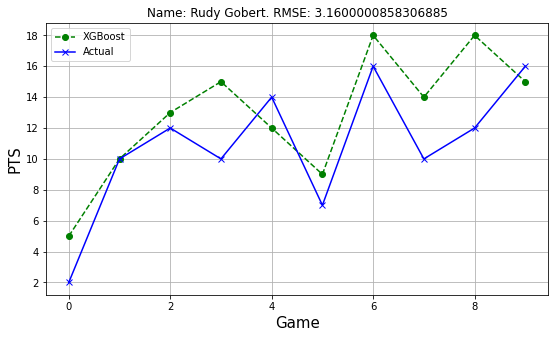

In [55]:
gru_rmse = np.sqrt(mse(xgb_forecasts, ytest.reshape(-1, )))

plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(ytest)), xgb_forecasts, color="green", linestyle="--", marker="o", label="XGBoost")
# plt.plot(np.arange(len(ytest)), gru_forecasts, color="black", linestyle="--", marker="o", label="GRU")
# plt.plot(np.arange(len(ytest)), forecasts, color="red", marker="o", label="FF")
plt.plot(np.arange(len(ytest)), ytest.reshape(-1, ), color="blue", marker="x", label="Actual")
plt.xlabel("Game", fontsize=15)
plt.ylabel(label1[0], fontsize=15)
plt.title(f"Name: {name}. RMSE: {round(gru_rmse, 2)}")
plt.grid()
plt.legend()
plt.show()

In [56]:
complete_log[label1].describe()

,PTS
count,204.000000
mean,14.323529
std,5.472118
min,0.000000
25%,10.000000
50%,14.000000
75%,18.000000
max,29.000000


In [57]:
complete_log[predictors+label1].corr()

,MIN,FGA,FG3A_x,FTA,HOME,AWAY,REST_DAYS,D_FGM,D_FGA,D_FG_PCT,PCT_PLUSMINUS,FG3M_y,FG3A_y,FG3_PCT_y,NS_FG3_PCT,PLUSMINUS_x,FG2M,FG2A,FG2_PCT,NS_FG2_PCT,PLUSMINUS_y,FGM_LT_10,FGA_LT_10,LT_10_PCT,NS_LT_10_PCT,PLUSMINUS,E_PACE,E_DEF_RATING,PTS
MIN,1.000000,0.320198,0.034933,0.275845,-0.121633,0.121633,-0.021131,-0.041741,0.022855,-0.078584,-0.041623,0.024538,0.022673,0.012198,-0.099803,0.053458,-0.053591,0.000706,-0.109076,-0.080647,-0.082554,-0.090365,-0.067770,-0.065267,-0.038965,-0.057780,0.017056,-0.046799,0.368134
FGA,0.320198,1.000000,0.080060,0.137608,0.016496,-0.016496,0.039443,0.109175,0.133673,0.037813,0.039292,0.009527,-0.024339,0.058108,0.092964,0.028393,0.100443,0.121407,-0.019866,-0.044788,-0.001023,0.054763,0.087429,-0.059985,-0.044716,-0.048912,0.080578,0.078979,0.758428
FG3A_x,0.034933,0.080060,1.000000,0.010553,-0.097247,0.097247,-0.053994,-0.041058,0.087691,-0.132696,-0.137712,-0.038447,0.015240,-0.098698,-0.021556,-0.098759,-0.018811,0.056314,-0.129189,-0.011894,-0.137493,-0.042849,0.030067,-0.147588,-0.003748,-0.155962,0.096025,-0.114633,0.008889
FTA,0.275845,0.137608,0.010553,1.000000,0.007662,-0.007662,-0.035443,-0.016065,0.050314,-0.061373,0.005043,-0.006102,0.043755,-0.077684,-0.157097,-0.022555,-0.012031,0.006279,-0.028799,-0.094113,0.014552,-0.076240,-0.084344,0.004926,-0.056239,0.025373,0.079730,-0.062327,0.501458
HOME,-0.121633,0.016496,-0.097247,0.007662,1.000000,-1.000000,0.097194,0.036569,0.040096,0.015774,0.016940,-0.034938,-0.047810,0.002838,0.033033,-0.009528,0.054418,0.066566,-0.010757,-0.005901,-0.009879,0.046391,0.050589,0.000084,0.007643,-0.001359,0.037010,-0.005711,0.068833
AWAY,0.121633,-0.016496,0.097247,-0.007662,-1.000000,1.000000,-0.097194,-0.036569,-0.040096,-0.015774,-0.016940,0.034938,0.047810,-0.002838,-0.033033,0.009528,-0.054418,-0.066566,0.010757,0.005901,0.009879,-0.046391,-0.050589,-0.000084,-0.007643,0.001359,-0.037010,0.005711,-0.068833
REST_DAYS,-0.021131,0.039443,-0.053994,-0.035443,0.097194,-0.097194,1.000000,0.075723,0.053822,0.061402,0.065517,-0.134576,-0.071104,-0.157676,-0.094138,-0.136828,0.146348,0.094650,0.117313,0.054577,0.103501,0.202587,0.142379,0.146877,0.073468,0.128395,0.053773,0.092268,0.071209
D_FGM,-0.041741,0.109175,-0.041058,-0.016065,0.036569,-0.036569,0.075723,1.000000,0.702908,0.793196,0.729602,0.220583,-0.061946,0.525912,0.136559,0.509815,0.848036,0.589227,0.602967,0.298575,0.518593,0.797065,0.674847,0.380388,0.261254,0.307374,0.581902,0.718166,0.033620
D_FGA,0.022855,0.133673,0.087691,0.050314,0.040096,-0.040096,0.053822,0.702908,1.000000,0.124970,0.116677,0.176523,0.133235,0.131836,0.039638,0.122727,0.584416,0.673151,-0.021278,0.043248,-0.045611,0.443336,0.598692,-0.205526,0.025387,-0.227795,0.674503,0.282039,0.093095
D_FG_PCT,-0.078584,0.037813,-0.132696,-0.061373,0.015774,-0.015774,0.061402,0.793196,0.124970,1.000000,0.918007,0.154089,-0.204022,0.621348,0.156747,0.606716,0.684017,0.248731,0.857821,0.379905,0.760659,0.732942,0.431193,0.704081,0.342049,0.621318,0.235600,0.761515,-0.031513
